#Code for Kazakh Speech based Speech Emotion Recognition Model

##The code working states:

* Important of libraries (librosa, numpy, tensorflow, matplotlib, keras, pandas)

* import the data (in our case dataset is extracted audio files from videos, MFCC(maybe other feature types))

* optimization and regulation of raw data to fit the model and separation of whole dataset to different parts to train, validate and test the Model

* construction of Main model architecture by using keras and tenserflow, (our model is CNN based, so there are Convolutional layers with BatchNormalization, AveragePooling, Dropout, Fully Connected and Final Softmax)

* after the model architecture creation, the main training of the model is conducted. The model trained with different learning rate factors and lr is dynamic, with fixed number of epochs that can be interupted and batch size which also can be regulated

* after the model is trained and validated, model is tested for testing dataset. F-1score, recall and precision metrics as well as accuracy were used to assess the performance of the model.

* (Optional) Graphs and Confusion matrix tables are needed to generally understhand the development of the model. Confusion matrix can be used to find out what classess are working poorly to make further improvements

In [1]:
#import libraries
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import seaborn as sns

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras import regularizers

import os
import glob
import pandas as pd
import IPython.display as ipd
import plotly.express as px
import scipy.io.wavfile
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
Features = pd.read_csv("/content/drive/MyDrive/KazSER/Dialogue Dataset/Features/features-kazser-dialogues-2.csv") #path to our table with names of videosX = Features.iloc[: ,:-1].values
X = Features.iloc[: ,:-1].values
Y = Features['labels']
print(X)

[[-3.82777466e+02  9.51852493e+01 -9.16613102e+00 ... -3.59960198e+00
  -5.95962191e+00 -3.66610670e+00]
 [-3.82776546e+02  9.51843875e+01 -9.16571775e+00 ... -3.59769803e+00
  -5.96082661e+00 -3.66505618e+00]
 [-4.16953094e+02  9.42567978e+01 -1.02480822e+01 ... -3.67724395e+00
  -4.82853031e+00 -4.08732224e+00]
 ...
 [-3.58895874e+02  1.15954056e+02 -1.82695901e+00 ... -6.74484730e-01
  -3.39623213e-01  4.27365780e+00]
 [-3.87724030e+02  1.16406654e+02  2.21849486e-01 ...  2.22788668e+00
  -1.02734923e+00  1.50382209e+00]
 [-3.81459747e+02  1.17963654e+02 -7.13011026e-01 ... -5.53506136e-01
   5.04008114e-01  4.42967176e+00]]


In [4]:
#to transform 1 length array to 7 length array
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()
print(Y)

[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 ...
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]]


In [5]:
#Split dataset for training, validation and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True, test_size=0.3)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, random_state=0, shuffle=True, test_size=0.5)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((180, 20), (180, 6), (39, 20), (39, 6))

In [6]:
#Code to scale all of the values in features values
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.fit_transform(x_val)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((180, 20), (180, 6), (39, 20), (39, 6))

In [7]:
#Expanding dimensionality of input values to fit the CNN MODEL
x_train = np.expand_dims(x_train, axis=2)
x_val = np.expand_dims(x_val, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((180, 20, 1), (180, 6), (39, 20, 1), (39, 6))

In [8]:
print(x_train.shape[1]) #to check the dimensions of the input features

20


In [9]:
import tensorflow.keras.layers as L
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dropout, Dense, BatchNormalization, AveragePooling1D

model=Sequential() #Model architecture
model.add(Conv1D(256, kernel_size=6, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(AveragePooling1D(pool_size=4, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=6, strides=1, padding='same', activation='relu'))
model.add(AveragePooling1D(pool_size=4, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=6, strides=1, padding='same', activation='relu'))
model.add(AveragePooling1D(pool_size=4, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=6, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=4, strides = 2, padding = 'same'))

model.add(Conv1D(32, kernel_size=6, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=4, strides = 2, padding = 'same'))

model.add(Conv1D(32, kernel_size=6, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=4, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=6, activation='softmax'))

model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 20, 256)             │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling1d (AveragePooling1D) │ (None, 10, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 10, 128)             │         196,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling1d_1                  │ (None, 5, 128)              │               0 │
│ (AveragePooling1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 5, 128)              │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling1d_2                  │ (None, 3, 128)              │               0 │
│ (AveragePooling1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 3, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 3, 64)               │          49,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 2, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 2, 32)               │          12,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 1, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 1, 32)               │           6,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 1, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 365,926 (1.40 MB)

 Trainable params: 365,926 (1.40 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.5, verbose=0, patience=5, min_lr=0.001)  #can change learning rate, patience and factor of learning rate change
history=model.fit(x_train, y_train, batch_size=16, epochs=50, validation_data=(x_val, y_val), callbacks=[rlrp]) #can change number of epochs and batch size

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.3212 - loss: 1.7808 - val_accuracy: 0.5897 - val_loss: 1.6322 - learning_rate: 0.0010
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5586 - loss: 1.5754 - val_accuracy: 0.5897 - val_loss: 1.3109 - learning_rate: 0.0010
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5291 - loss: 1.4298 - val_accuracy: 0.5897 - val_loss: 1.2134 - learning_rate: 0.0010
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5719 - loss: 1.3620 - val_accuracy: 0.5897 - val_loss: 1.2468 - learning_rate: 0.0010
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4955 - loss: 1.3325 - val_accuracy: 0.5897 - val_loss: 1.1664 - learning_rate: 0.0010
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.5464 - loss: 1.3637 - val_accuracy: 0.5897 - val_loss: 1.2017 - learning_rate: 0.0010
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5465 - loss: 1.3052 - val_acc

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6907 - loss: 0.8339 
Accuracy of our model on test data :  69.2307710647583 %


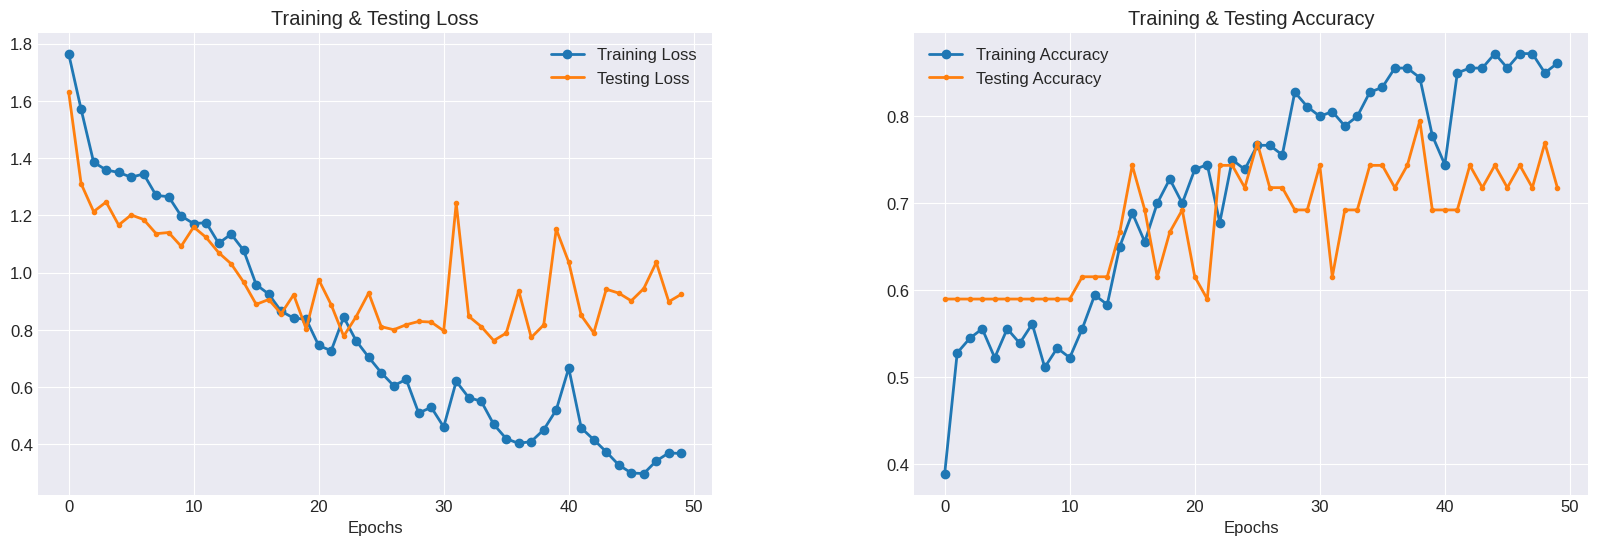

In [11]:
#Plotting the accuracy and the change of accuracy and loss for each epoch of training and validation

print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'font.size': 12})
epochs = [i for i in range(50)] #should be number of epochs
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss',marker='o', linewidth=2)
ax[0].plot(epochs , test_loss , label = 'Testing Loss',marker='.', linewidth=2)
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy',marker='o', linewidth=2)
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy',marker='.', linewidth=2)
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")

plt.subplots_adjust(wspace=0.3)
plt.show()

In [12]:
#to compare each outcome of Model with actual labels
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

display(df.head())

NameError: name 'y_pred' is not defined

In [ ]:
#to construct confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Purples', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred)) # to print the f1score, recall and precision and average value for each

In [ ]:
#code to store the model architecture in the json file and the weights
from tensorflow.keras.models import Sequential, model_from_json

model_json = model.to_json()

with open("model.json", "w") as json_file:

    json_file.write(model_json)

model.save_weights("weights.h5")

print("Saved model to disk")